In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
from keras.engine import data_adapter
import h5py

tf.keras.backend.set_floatx('float32')

plt.rcParams.update({
    "text.usetex":True,
    "font.family":"serif"
})

In [3]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

array = np.array
float32 = np.float32
int32 = np.int32
float64 = np.float64
int64 = np.int64

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/new_lorenz


In [7]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, plot_reconstructed_data_KS, plot_latent_states_KS , readAndReturnLossHistories, plot_histogram_and_save
from tools.ae_v2 import Autoencoder
from tools.GRU_AR_v1 import AR_RNN_GRU as AR_RNN
# from tools.LSTM_AR_v2 import AR_RNN_LSTM as AR_RNN
from tools.AEGRU_AR_v1 import AR_AERNN_GRU
from tools.trainAERNN import trainAERNN

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpoin?tAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 1
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

2023-07-09 22:29:56.953267: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-09 22:29:56.953505: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-09 22:29:56.993842: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-09 22:29:56.994100: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-09 22:29:56.994326: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2023-07-09 22:29:56.996449: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-09 22:29:56.996749: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-09 22:29:56.997005: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-09 22:29:57.540723: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-09 22:29:57.540934: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [10]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print('')
print(tf.config.list_logical_devices())
print('')
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]

2.8.1


# KS System

In [11]:
# setting up params (and saving, if applicable)
from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # RNN directory
    dir_name_rnn = os.getcwd()+'/saved_rnn/rnn_005'

    # making AR-RNN save directory
    dir_name_ARrnn = os.getcwd() + dir_sep + 'saved_AR_AERNN_rnn'
    if not os.path.isdir(dir_name_ARrnn):
        os.makedirs(dir_name_ARrnn)

    counter = 0
    while True:
        dir_check = 'AR_rnn_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_ARrnn + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_ARrnn = dir_name_ARrnn + dir_sep + dir_check
    os.makedirs(dir_name_ARrnn)
    os.makedirs(dir_name_ARrnn+dir_sep+'plots')
    
    # reading RNN paramaters
    with open(dir_name_rnn + '/RNN_specific_data.txt') as f:
        lines = f.readlines()

    params_rnn_dict = eval(''.join(lines))

    dt_rnn = params_rnn_dict['dt_rnn']
    return_params_arr = params_rnn_dict['return_params_arr']
    params = params_rnn_dict['params']
    try:
        normalize_dataset = params_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in rnn_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        normalization_type = params_rnn_dict['normalization_type']
    except:
        print("'normalization_type' not present in RNN_specific_data, set to 'stddev'.")
        normalization_type = 'stddev'
    try:
        dense_layer_act_func = params_rnn_dict['dense_layer_act_func']
    except:
        print("'dense_layer_act_func' not present in RNN_specific_data, set to 'linear'.")
        dense_layer_act_func = 'linear'
    try:
        stateful = params_rnn_dict['stateful']
    except:
        print("'stateful' not present in RNN_specific_data, set to True.")
        stateful = True
    try:
        use_learnable_state = params_rnn_dict['use_learnable_state']
    except:
        print("'use_learnable_state' not present in RNN_specific_data, set to False.")
        use_learnable_state = False
    try:
        use_weights_post_dense = params_rnn_dict['use_weights_post_dense']
    except:
        print("'use_weights_post_dense' not present in RNN_specific_data, set to False.")
        use_weights_post_dense = False
        
    
    # training params
    with open(dir_name_rnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    try:
        fRMS = tparams_dict['fRMS']
    except:
        fRMS = 0.0

    loss_weights = 0.98
else:
    # AR-RNN directory
    dir_name_ARrnn = os.getcwd()+'/saved_AR_AERNN_rnn/AR_AErnn_000'

    # reading AR-RNN parameters
    with open(dir_name_ARrnn + '/AR_rnn_specific_data.txt') as f:
        lines = f.readlines()
    
    params_AR_rnn_dict = eval(''.join(lines))

    dir_name_rnn = params_AR_rnn_dict['dir_name_rnn']
    rnn_idx = dir_name_rnn[-3:]
    dir_name_rnn = os.getcwd()+'/saved_rnn/rnn_'+rnn_idx

    dt_rnn = params_AR_rnn_dict['dt_rnn']
    T_sample_input = params_AR_rnn_dict['T_sample_input']
    T_sample_output = params_AR_rnn_dict['T_sample_output']
    T_offset = params_AR_rnn_dict['T_offset']
    return_params_arr = params_AR_rnn_dict['return_params_arr']
    params = params_AR_rnn_dict['params']
    try:
        normalize_dataset = params_AR_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in AR_rnn_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_AR_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_AR_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        use_ae_data = params_AR_rnn_dict['use_ae_data']
    except:
        print("'use_ae_data' not present in RNN_specific_data, set to True.")
        use_ae_data = True

    # training params
    with open(dir_name_ARrnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    learning_rate_list = tparams_dict['learning_rate_list']
    epochs = tparams_dict['epochs']
    patience = tparams_dict['patience']
    min_delta = tparams_dict['min_delta']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    try:
        fRMS = tparams_dict['fRMS']
    except:
        fRMS = 0.0
    try:
        loss_weights = tparams_dict['loss_weights']
    except:
        loss_weights = None
    if 'freeze_layers' in tparams_dict.keys():
        freeze_layers = tparams_dict['freeze_layers']
    else:
        freeze_layers = None
    if 'clipnorm' in tparams_dict.keys():
        clipnorm = tparams_dict['clipnorm']
    else:
        clipnorm = None
    


# reading stddev
with open(dir_name_rnn + '/final_net/final_net_class_dict.txt') as f:
    lines = f.readlines()
finalnet_dict = eval(''.join(lines))
stddev = finalnet_dict['stddev']
# stddev = 0.0

# reading RNN normalization constants
normalization_arr_rnn = None
if normalize_dataset == True:
    with open(dir_name_rnn + '/final_net/rnn_normalization.txt') as f:
        lines = f.readlines()
    normarr_rnn_dict = eval(''.join(lines))
    normalization_arr_rnn = normarr_rnn_dict['normalization_arr']

if os.path.exists(dir_name_rnn+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_rnn+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_arr_rnn = fl['normalization_arr'][0]

# reading AE directory
with open(dir_name_rnn + '/sim_data_AE_params.txt') as f:
    lines = f.readlines()

params_dict = eval(''.join(lines))

dir_name_ae = params_dict['dir_name_ae']
ae_idx = dir_name_ae[-3:]
dir_name_ae = os.getcwd()+'/saved_ae/ae_'+ae_idx
try:
    use_ae_data = params_dict['use_ae_data']
except:
    print("'use_ae_data' not present in sim_data_AE_params, set to True.")
    use_ae_data = True

# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']
normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]
try:
    ae_data_with_params = params_dict['ae_data_with_params']
except:
    print("'ae_data_with_params' not present in RNN_specific_data, set to True.")
    ae_data_with_params = True

print('dir_name_AR_AErnn:', dir_name_ARrnn)
print('dir_name_rnn:', dir_name_rnn)
print('dir_name_ae:', dir_name_ae)
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state = params_dict['init_state']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

with np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True) as fl:
    all_data = fl['all_data'].astype(FTYPE)
    boundary_idx_arr = fl['boundary_idx_arr']
    normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
    initial_t0 = fl['initial_t0']
    init_state_mat = fl['init_state_mat']

    lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']


test_split = 1 - train_split - val_split

# setting seed for PRNGs
np.random.seed(prng_seed)
tf.random.set_seed(prng_seed)

dir_name_AR_AErnn: /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_005
dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_rnn/rnn_005
dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_ae/ae_024
data_dir_idx: 010
normalize_flag_ogdata: False


In [12]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.9058021372262592, lyapunov time : 1.1039938926696777s


In [13]:
# delaing with normalizing the data before feeding into autoencoder
num_params = params_mat.shape[1]
og_vars = all_data.shape[1]
if alldata_withparams_flag == True:
    og_vars -= num_params

# if use_ae_data == True:
#     if ae_data_with_params == True and alldata_withparams_flag == False:
#         new_all_data = np.empty(shape=(all_data.shape[0], og_vars+num_params), dtype=FTYPE)
#         new_all_data[:, 0:og_vars] = all_data[:, 0:og_vars]
#         del(all_data)
#         all_data = new_all_data
#         prev_idx = 0
#         for i in range(boundary_idx_arr.shape[0]):
#             all_data[prev_idx:boundary_idx_arr[i], num_params:] = params_mat[i]
#             prev_idx = boundary_idx_arr[i]

#     if normalizeforae_flag == True:
#         for i in range(all_data.shape[1]):
#             all_data[:, i] -= normalization_constant_arr_aedata[0, i]
#             all_data[:, i] /= normalization_constant_arr_aedata[1, i]

#     if ae_data_with_params == False:
#         all_data = all_data[:, 0:og_vars]
# else:
#     # using raw data, neglecting the params attached (if any)
#     all_data = all_data[:, 0:og_vars]

if use_ae_data == True and ae_data_with_params == False:
    all_data = all_data[:, 0:og_vars]
else:
    all_data = all_data[:, 0:og_vars]
    
normalization_constant_arr_aedata = normalization_constant_arr_aedata[:, 0:all_data.shape[1]]

# Autoencoder

In [14]:
# if use_ae_data == True:
#     load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
#     wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

In [15]:
# if use_ae_data == True:
#     ae_net = Autoencoder(all_data.shape[1], load_file=load_file)
#     ae_net.load_weights_from_file(wt_file)

# GRU

In [16]:
if behaviour == 'initialiseAndTrainFromScratch':
    # RNN data parameters
    num_lyaptimesteps_totrain = np.array([
        5, 
        10,
        15,
        20,
        # 70,
    ])*dt_rnn/np.mean(lyapunov_time_arr)
    num_timesteps_warmup = 1*np.mean(lyapunov_time_arr)/dt_rnn
    T_sample_input = num_timesteps_warmup*dt_rnn
    T_sample_output = num_lyaptimesteps_totrain*np.mean(lyapunov_time_arr)
    T_offset = T_sample_input
    skip_intermediate = 'full sample'
    stateful = True
    if return_params_arr != False:
        params = params_arr
    else:
        params = None

    # saving AR RNN specific data
    AR_RNN_specific_data = {
        'dt_rnn':dt_rnn,
        'T_sample_input':T_sample_input,
        'T_sample_output':T_sample_output,
        'T_offset':T_offset,
        'boundary_idx_arr':boundary_idx_arr,
        'delta_t':delta_t,
        'params':params,
        'return_params_arr':return_params_arr,
        'normalize_dataset':normalize_dataset,
        'num_lyaptimesteps_totrain':num_lyaptimesteps_totrain,
        'num_timesteps_warmup':num_timesteps_warmup,
        'dir_name_rnn':dir_name_rnn,
        'dir_name_ae':dir_name_ae,
        'stddev_multiplier':stddev_multiplier,
        'skip_intermediate':skip_intermediate,
        'module':AR_RNN.__module__,
        'normalization_type':normalization_type,
        'use_ae_data':use_ae_data,
        'stateful':stateful,
    }

    with open(dir_name_ARrnn+dir_sep+'AR_RNN_specific_data.txt', 'w') as f:
        f.write(str(AR_RNN_specific_data))

In [17]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_list = [
        [1e-3, 5e-4, 1e-4],
        [1e-4, 5e-5, 1e-5],
        [1e-5, 5e-6, 1e-6],
        [1e-6, 5e-7, 1e-7],
        # [5e-7],
    ]
    epochs = [
        [200]*len(learning_rate_list[0]),
        [200]*len(learning_rate_list[1]),
        [200]*len(learning_rate_list[2]),
        [200]*len(learning_rate_list[3]),
        # [1000],
    ]
    patience = [
        [20]*len(learning_rate_list[0]),
        [20]*len(learning_rate_list[1]),
        [20]*len(learning_rate_list[2]),
        [20]*len(learning_rate_list[3]),
        # [50],
    ] # parameter for early stopping
    min_delta = 5e-6  # parameter for early stopping
    lambda_reg = 5e-7  # weight for regularizer
    covmat_lmda = 1e-4  # weight for the covmat loss

    if loss_weights is None:
        loss_weights = 1.0
        
    freeze_layers = [
        [],
        [],
        [],
        [],
        [],
    ]
    
    clipnorm = None #1.0
    batch_size = [
        32,
        32,
        32,
        32,
        # 32,
    ]
    
    # saving training params
    training_specific_params = {
        'learning_rate_list':learning_rate_list,
        'epochs':epochs,
        'patience':patience,
        'min_delta':min_delta,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size,
        'fRMS':fRMS,
        'loss_weights':loss_weights,
        'stddev':stddev,
        'covmat_lmda':covmat_lmda,
        'freeze_layers':freeze_layers,
        'clipnorm':clipnorm,
    }

    with open(dir_name_ARrnn+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
    
    np.savez(
        dir_name_ARrnn+dir_sep+'normalization_data',
        normalization_arr=[normalization_arr_rnn],
    )

In [18]:
if behaviour == 'initialiseAndTrainFromScratch':
    load_file_rnn = dir_name_rnn + '/final_net/final_net_class_dict.txt'
    wt_file_rnn = dir_name_rnn+'/final_net/final_net_gru_weights.h5'
    
    load_file_ae = dir_name_ae+'/final_net/final_net_class_dict.txt'
    wt_file_ae = dir_name_ae+'/final_net/final_net_ae_weights.h5'



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 5 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : None
82/82 [==============================] - 9s 26ms/step - loss: 0.0692 - mse: 0.0081 - NMSE: 0.0732 - covmat_fro_loss: 0.0000e+00 - global_gradnorm: 0.0000e+00
baseline : 7.3220E-02


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
655/656 [============================>.] - ETA: 0s - loss: 0.1627 - mse: 0.0190 - NMSE: 0.1721 - covmat_fro_loss: 3.7638e-04 - global_gradnorm: 28.5091 - tot_time: 0h 0m 56.9s

Epoch 1: val_NMSE improved from 0.07322 to 0.05764, saving model to /home/rkaushik/Documents/Th

Epoch 12/200
656/656 [==============================] - ETA: 0s - loss: 0.0475 - mse: 0.0054 - NMSE: 0.0492 - covmat_fro_loss: 1.9666e-04 - global_gradnorm: 4.4647 - tot_time: 0h 7m 40.2s

Epoch 12: val_NMSE did not improve from 0.02655
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-5_outsteps
656/656 [==============================] - 37s 56ms/step - loss: 0.0475 - mse: 0.0054 - NMSE: 0.0492 - covmat_fro_loss: 1.9674e-04 - global_gradnorm: 4.4639 - val_loss: 0.0568 - val_mse: 0.0065 - val_NMSE: 0.0591 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 13/200
655/656 [============================>.] - ETA: 0s - loss: 0.0646 - mse: 0.0074 - NMSE: 0.0671 - covmat_fro_loss: 2.3244e-04 - global_gradnorm: 4.8855 - tot_time: 0h 8m 17.1s

Epoch 13: val_NMSE did not improve from 0.02655
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN

656/656 [==============================] - ETA: 0s - loss: 0.0504 - mse: 0.0058 - NMSE: 0.0529 - covmat_fro_loss: 1.9319e-04 - global_gradnorm: 7.2914 - tot_time: 0h 15m 4.3s

Epoch 1: val_NMSE improved from 0.02655 to 0.01229, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-5_outsteps
656/656 [==============================] - 36s 55ms/step - loss: 0.0504 - mse: 0.0058 - NMSE: 0.0529 - covmat_fro_loss: 1.9305e-04 - global_gradnorm: 7.2827 - val_loss: 0.0121 - val_mse: 0.0014 - val_NMSE: 0.0123 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 2/200
656/656 [==============================] - ETA: 0s - loss: 0.0449 - mse: 0.0052 - NMSE: 0.0472 - covmat_fro_loss: 1.8265e-04 - global_gradnorm: 6.8764 - tot_time: 0h 15m 40.8s

Epoch 2: val_NMSE d

656/656 [==============================] - ETA: 0s - loss: 0.0330 - mse: 0.0038 - NMSE: 0.0342 - covmat_fro_loss: 1.5487e-04 - global_gradnorm: 5.3497 - tot_time: 0h 22m 27.9s

Epoch 13: val_NMSE did not improve from 0.01229
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-5_outsteps
656/656 [==============================] - 37s 56ms/step - loss: 0.0330 - mse: 0.0038 - NMSE: 0.0342 - covmat_fro_loss: 1.5485e-04 - global_gradnorm: 5.3663 - val_loss: 0.0265 - val_mse: 0.0030 - val_NMSE: 0.0274 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 14/200
656/656 [==============================] - ETA: 0s - loss: 0.0305 - mse: 0.0035 - NMSE: 0.0315 - covmat_fro_loss: 1.4844e-04 - global_gradnorm: 5.0014 - tot_time: 0h 23m 3.5s

Epoch 14: val_NMSE did not improve from 0.01229
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_

Epoch 25/200
655/656 [============================>.] - ETA: 0s - loss: 0.0241 - mse: 0.0027 - NMSE: 0.0245 - covmat_fro_loss: 1.3644e-04 - global_gradnorm: 3.5725 - tot_time: 0h 29m 44.0s

Epoch 25: val_NMSE did not improve from 0.01100
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-5_outsteps
656/656 [==============================] - 37s 56ms/step - loss: 0.0241 - mse: 0.0027 - NMSE: 0.0245 - covmat_fro_loss: 1.3643e-04 - global_gradnorm: 3.5807 - val_loss: 0.0235 - val_mse: 0.0026 - val_NMSE: 0.0239 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 26/200
655/656 [============================>.] - ETA: 0s - loss: 0.0270 - mse: 0.0030 - NMSE: 0.0275 - covmat_fro_loss: 1.4141e-04 - global_gradnorm: 3.5829 - tot_time: 0h 30m 20.3s

Epoch 26: val_NMSE did not improve from 0.01100
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AER

656/656 [==============================] - ETA: 0s - loss: 0.0098 - mse: 0.0011 - NMSE: 0.0095 - covmat_fro_loss: 8.1448e-05 - global_gradnorm: 2.0767 - tot_time: 0h 36m 59.2s

Epoch 1: val_NMSE improved from 0.01100 to 0.01017, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-5_outsteps
656/656 [==============================] - 36s 55ms/step - loss: 0.0098 - mse: 0.0011 - NMSE: 0.0095 - covmat_fro_loss: 8.1442e-05 - global_gradnorm: 2.0764 - val_loss: 0.0103 - val_mse: 0.0011 - val_NMSE: 0.0102 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 2/200
656/656 [==============================] - ETA: 0s - loss: 0.0098 - mse: 0.0011 - NMSE: 0.0096 - covmat_fro_loss: 7.8844e-05 - global_gradnorm: 2.5007 - tot_time: 0h 37m 35.2s

Epoch 2: val_NMSE 

Epoch 13/200
656/656 [==============================] - ETA: 0s - loss: 0.0091 - mse: 9.6988e-04 - NMSE: 0.0088 - covmat_fro_loss: 7.2082e-05 - global_gradnorm: 3.1192 - tot_time: 0h 44m 14.4s

Epoch 13: val_NMSE did not improve from 0.00653
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-5_outsteps
656/656 [==============================] - 37s 56ms/step - loss: 0.0091 - mse: 9.6988e-04 - NMSE: 0.0088 - covmat_fro_loss: 7.2093e-05 - global_gradnorm: 3.1181 - val_loss: 0.0121 - val_mse: 0.0013 - val_NMSE: 0.0120 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 14/200
655/656 [============================>.] - ETA: 0s - loss: 0.0082 - mse: 8.6892e-04 - NMSE: 0.0079 - covmat_fro_loss: 7.1280e-05 - global_gradnorm: 3.2265 - tot_time: 0h 44m 50.5s

Epoch 14: val_NMSE did not improve from 0.00653
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/

Epoch 25/200
655/656 [============================>.] - ETA: 0s - loss: 0.0084 - mse: 8.9855e-04 - NMSE: 0.0081 - covmat_fro_loss: 6.8317e-05 - global_gradnorm: 3.5373 - tot_time: 0h 51m 32.9s

Epoch 25: val_NMSE did not improve from 0.00526
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-5_outsteps
656/656 [==============================] - 36s 56ms/step - loss: 0.0085 - mse: 9.0032e-04 - NMSE: 0.0082 - covmat_fro_loss: 6.8446e-05 - global_gradnorm: 3.5654 - val_loss: 0.0108 - val_mse: 0.0012 - val_NMSE: 0.0107 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 26/200
655/656 [============================>.] - ETA: 0s - loss: 0.0091 - mse: 9.7613e-04 - NMSE: 0.0088 - covmat_fro_loss: 7.0650e-05 - global_gradnorm: 3.5994 - tot_time: 0h 52m 9.6s

Epoch 26: val_NMSE did not improve from 0.00526
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/s

Epoch 37/200
656/656 [==============================] - ETA: 0s - loss: 0.0079 - mse: 8.3941e-04 - NMSE: 0.0076 - covmat_fro_loss: 6.4063e-05 - global_gradnorm: 3.3791 - tot_time: 0h 58m 51.9s

Epoch 37: val_NMSE improved from 0.00355 to 0.00352, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/checkpoint-5_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-5_outsteps
656/656 [==============================] - 37s 56ms/step - loss: 0.0079 - mse: 8.3941e-04 - NMSE: 0.0076 - covmat_fro_loss: 6.4025e-05 - global_gradnorm: 3.3763 - val_loss: 0.0041 - val_mse: 3.8830e-04 - val_NMSE: 0.0035 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 38/200
656/656 [==============================] - ETA: 0s - loss: 0.0063 - mse: 6.4710e-04 - NMSE: 0.0059 - covmat_fro_loss: 5.6914e-05 - global_gradnorm: 2.3902 - tot_time: 0

Epoch 49/200
656/656 [==============================] - ETA: 0s - loss: 0.0089 - mse: 9.4690e-04 - NMSE: 0.0086 - covmat_fro_loss: 7.3287e-05 - global_gradnorm: 3.6577 - tot_time: 1h 6m 12.2s

Epoch 49: val_NMSE did not improve from 0.00352
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-5_outsteps
656/656 [==============================] - 38s 58ms/step - loss: 0.0089 - mse: 9.4690e-04 - NMSE: 0.0086 - covmat_fro_loss: 7.3318e-05 - global_gradnorm: 3.6636 - val_loss: 0.0051 - val_mse: 5.0086e-04 - val_NMSE: 0.0045 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 50/200
656/656 [==============================] - ETA: 0s - loss: 0.0086 - mse: 9.0862e-04 - NMSE: 0.0082 - covmat_fro_loss: 6.9362e-05 - global_gradnorm: 3.1129 - tot_time: 1h 6m 50.0s

Epoch 50: val_NMSE did not improve from 0.00352
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_loren

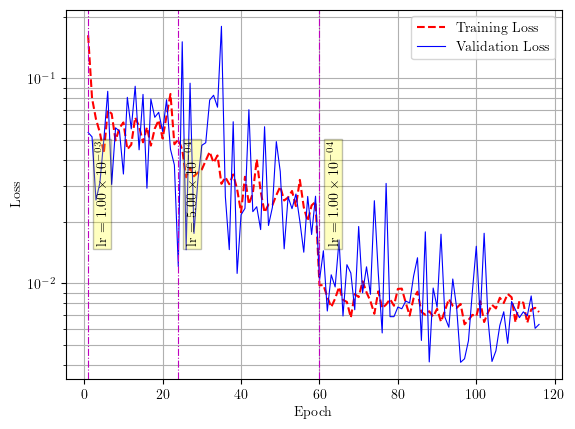

<Figure size 640x480 with 0 Axes>

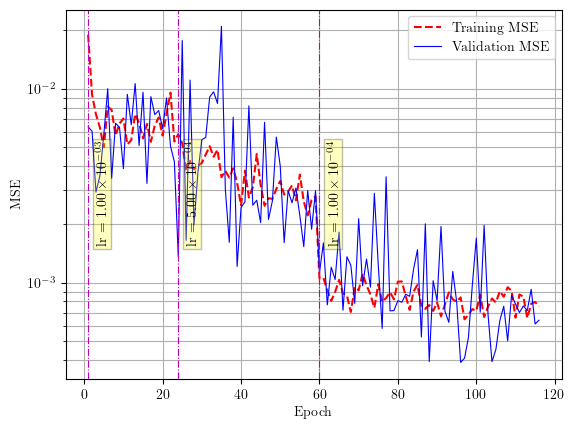

<Figure size 640x480 with 0 Axes>

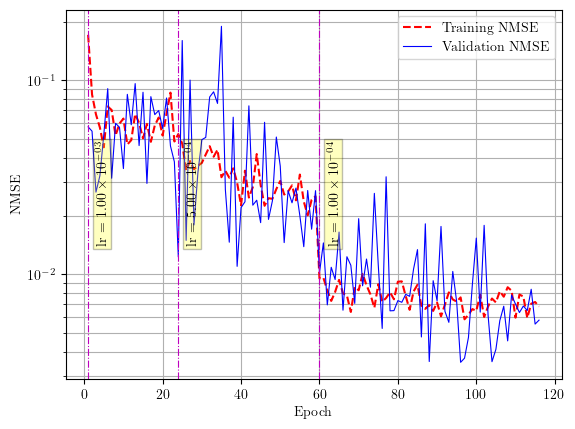

<Figure size 640x480 with 0 Axes>

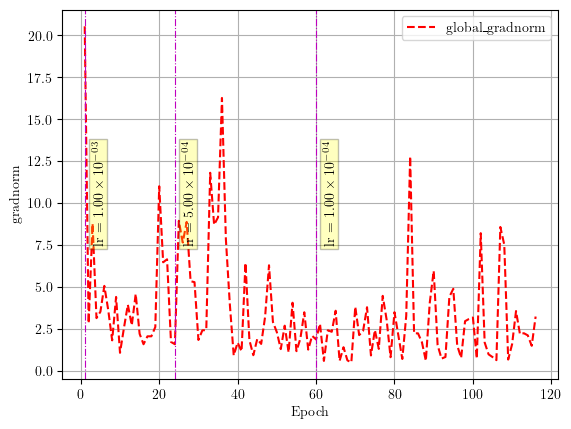



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 10 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : 16.3
62/62 [==============================] - 14s 36ms/step - loss: 0.0259 - mse: 0.0032 - NMSE: 0.0292 - covmat_fro_loss: 0.0000e+00 - global_gradnorm: 0.0000e+00
baseline : 2.9247E-02


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.0001 ----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
500/500 [==============================] - ETA: 0s - loss: 0.0763 - mse: 0.0096 - NMSE: 0.0870 - covmat_fro_loss: 2.3024e-04 - global_gradnorm: 14.9839 - tot_time: 0h 1m 24.5s

Epoch 1: val_NMSE did not improve from 0.02925
 - saving loss histories at /home/rkaushik/Docu

Epoch 12/200
500/500 [==============================] - ETA: 0s - loss: 0.0481 - mse: 0.0060 - NMSE: 0.0539 - covmat_fro_loss: 2.2186e-04 - global_gradnorm: 12.8687 - tot_time: 0h 9m 52.6s

Epoch 12: val_NMSE did not improve from 0.02925
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-10_outsteps
500/500 [==============================] - 46s 92ms/step - loss: 0.0481 - mse: 0.0060 - NMSE: 0.0539 - covmat_fro_loss: 2.2183e-04 - global_gradnorm: 12.8755 - val_loss: 0.0282 - val_mse: 0.0034 - val_NMSE: 0.0311 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 13/200
500/500 [==============================] - ETA: 0s - loss: 0.0490 - mse: 0.0061 - NMSE: 0.0550 - covmat_fro_loss: 2.2469e-04 - global_gradnorm: 12.9815 - tot_time: 0h 10m 38.2s

Epoch 13: val_NMSE did not improve from 0.02925
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_

500/500 [==============================] - ETA: 0s - loss: 0.0316 - mse: 0.0039 - NMSE: 0.0351 - covmat_fro_loss: 1.9125e-04 - global_gradnorm: 11.1265 - tot_time: 0h 18m 21.0s

Epoch 3: val_NMSE improved from 0.02585 to 0.02244, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-10_outsteps
500/500 [==============================] - 47s 94ms/step - loss: 0.0316 - mse: 0.0039 - NMSE: 0.0351 - covmat_fro_loss: 1.9123e-04 - global_gradnorm: 11.1067 - val_loss: 0.0208 - val_mse: 0.0025 - val_NMSE: 0.0224 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 4/200
500/500 [==============================] - ETA: 0s - loss: 0.0302 - mse: 0.0037 - NMSE: 0.0334 - covmat_fro_loss: 1.8604e-04 - global_gradnorm: 11.2319 - tot_time: 0h 19m 7.8s

Epoch 4: val_N

Epoch 15/200
500/500 [==============================] - ETA: 0s - loss: 0.0294 - mse: 0.0036 - NMSE: 0.0326 - covmat_fro_loss: 1.7206e-04 - global_gradnorm: 11.3734 - tot_time: 0h 27m 36.3s

Epoch 15: val_NMSE improved from 0.02204 to 0.02094, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-10_outsteps
500/500 [==============================] - 47s 93ms/step - loss: 0.0294 - mse: 0.0036 - NMSE: 0.0326 - covmat_fro_loss: 1.7202e-04 - global_gradnorm: 11.3603 - val_loss: 0.0195 - val_mse: 0.0023 - val_NMSE: 0.0209 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 16/200
500/500 [==============================] - ETA: 0s - loss: 0.0278 - mse: 0.0034 - NMSE: 0.0307 - covmat_fro_loss: 1.7376e-04 - global_gradnorm: 10.8558 - tot_time: 0h 28m 22.8s

Epoch 27/200
500/500 [==============================] - ETA: 0s - loss: 0.0299 - mse: 0.0037 - NMSE: 0.0331 - covmat_fro_loss: 1.7090e-04 - global_gradnorm: 11.2519 - tot_time: 0h 36m 50.0s

Epoch 27: val_NMSE did not improve from 0.01919
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-10_outsteps
500/500 [==============================] - 47s 93ms/step - loss: 0.0299 - mse: 0.0037 - NMSE: 0.0331 - covmat_fro_loss: 1.7101e-04 - global_gradnorm: 11.2620 - val_loss: 0.0240 - val_mse: 0.0029 - val_NMSE: 0.0263 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 28/200
500/500 [==============================] - ETA: 0s - loss: 0.0268 - mse: 0.0033 - NMSE: 0.0296 - covmat_fro_loss: 1.7065e-04 - global_gradnorm: 11.0396 - tot_time: 0h 37m 36.0s

Epoch 28: val_NMSE did not improve from 0.01919
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR

Epoch 39/200
500/500 [==============================] - ETA: 0s - loss: 0.0267 - mse: 0.0033 - NMSE: 0.0295 - covmat_fro_loss: 1.6769e-04 - global_gradnorm: 10.5724 - tot_time: 0h 46m 3.8s

Epoch 39: val_NMSE did not improve from 0.01668
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-10_outsteps
500/500 [==============================] - 45s 89ms/step - loss: 0.0267 - mse: 0.0033 - NMSE: 0.0295 - covmat_fro_loss: 1.6771e-04 - global_gradnorm: 10.5838 - val_loss: 0.0190 - val_mse: 0.0023 - val_NMSE: 0.0206 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 40/200
500/500 [==============================] - ETA: 0s - loss: 0.0260 - mse: 0.0032 - NMSE: 0.0287 - covmat_fro_loss: 1.6150e-04 - global_gradnorm: 10.6371 - tot_time: 0h 46m 49.6s

Epoch 40: val_NMSE did not improve from 0.01668
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_

Epoch 51/200
500/500 [==============================] - ETA: 0s - loss: 0.0260 - mse: 0.0032 - NMSE: 0.0286 - covmat_fro_loss: 1.6561e-04 - global_gradnorm: 10.6702 - tot_time: 0h 55m 23.1s

Epoch 51: val_NMSE did not improve from 0.01517
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-10_outsteps
500/500 [==============================] - 47s 94ms/step - loss: 0.0260 - mse: 0.0032 - NMSE: 0.0286 - covmat_fro_loss: 1.6554e-04 - global_gradnorm: 10.6542 - val_loss: 0.0245 - val_mse: 0.0030 - val_NMSE: 0.0270 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 52/200
500/500 [==============================] - ETA: 0s - loss: 0.0264 - mse: 0.0032 - NMSE: 0.0291 - covmat_fro_loss: 1.6340e-04 - global_gradnorm: 10.7676 - tot_time: 0h 56m 9.2s

Epoch 52: val_NMSE did not improve from 0.01517
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_

Epoch 63/200
500/500 [==============================] - ETA: 0s - loss: 0.0270 - mse: 0.0033 - NMSE: 0.0298 - covmat_fro_loss: 1.6727e-04 - global_gradnorm: 10.5595 - tot_time: 1h 4m 40.5s

Epoch 63: val_NMSE did not improve from 0.01481
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-10_outsteps
500/500 [==============================] - 47s 94ms/step - loss: 0.0270 - mse: 0.0033 - NMSE: 0.0298 - covmat_fro_loss: 1.6732e-04 - global_gradnorm: 10.5617 - val_loss: 0.0162 - val_mse: 0.0019 - val_NMSE: 0.0173 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 64/200
500/500 [==============================] - ETA: 0s - loss: 0.0270 - mse: 0.0033 - NMSE: 0.0298 - covmat_fro_loss: 1.6402e-04 - global_gradnorm: 10.4564 - tot_time: 1h 5m 27.2s

Epoch 64: val_NMSE did not improve from 0.01481
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_A

500/500 [==============================] - ETA: 0s - loss: 0.0245 - mse: 0.0030 - NMSE: 0.0270 - covmat_fro_loss: 1.4778e-04 - global_gradnorm: 10.1360 - tot_time: 1h 13m 56.2s

Epoch 75: val_NMSE did not improve from 0.01481
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-10_outsteps
500/500 [==============================] - 46s 92ms/step - loss: 0.0245 - mse: 0.0030 - NMSE: 0.0270 - covmat_fro_loss: 1.4792e-04 - global_gradnorm: 10.1483 - val_loss: 0.0413 - val_mse: 0.0052 - val_NMSE: 0.0467 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 76/200
500/500 [==============================] - ETA: 0s - loss: 0.0233 - mse: 0.0028 - NMSE: 0.0256 - covmat_fro_loss: 1.5046e-04 - global_gradnorm: 10.1902 - tot_time: 1h 14m 42.4s

Epoch 76: val_NMSE did not improve from 0.01481
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-10_outsteps
500/500 [==============================] - 45s 90ms/step - loss: 0.0140 - mse: 0.0016 - NMSE: 0.0149 - covmat_fro_loss: 1.2345e-04 - global_gradnorm: 7.9729 - val_loss: 0.0133 - val_mse: 0.0015 - val_NMSE: 0.0140 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 10/200
500/500 [==============================] - ETA: 0s - loss: 0.0141 - mse: 0.0017 - NMSE: 0.0150 - covmat_fro_loss: 1.2300e-04 - global_gradnorm: 7.8949 - tot_time: 1h 23m 7.9s

Epoch 10: val_NMSE did not improve from 0.01122
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-10_outsteps
500/500 [==============================] - 46s 91ms/step - loss: 0.0141 - mse: 0.0017 - NMSE: 0.0150 - covmat_fro_loss: 1.2307e-04 - global_gradnorm: 7.9116 - val_loss: 0.0

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-10_outsteps
500/500 [==============================] - 45s 91ms/step - loss: 0.0124 - mse: 0.0014 - NMSE: 0.0131 - covmat_fro_loss: 1.1592e-04 - global_gradnorm: 8.0029 - val_loss: 0.0110 - val_mse: 0.0013 - val_NMSE: 0.0114 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 22/200
500/500 [==============================] - ETA: 0s - loss: 0.0130 - mse: 0.0015 - NMSE: 0.0138 - covmat_fro_loss: 1.1527e-04 - global_gradnorm: 7.8939 - tot_time: 1h 32m 23.2s

Epoch 22: val_NMSE did not improve from 0.01091
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-10_outsteps
500/500 [==============================] - 45s 91ms/step - loss: 0.0130 - mse: 0.0015 - NMSE: 0.0138 - covmat_fro_loss: 1.1523e-04 - global_gradnorm: 7.8813 - val_loss: 0.

500/500 [==============================] - ETA: 0s - loss: 0.0129 - mse: 0.0015 - NMSE: 0.0136 - covmat_fro_loss: 1.1288e-04 - global_gradnorm: 8.3436 - tot_time: 1h 40m 49.0s

Epoch 33: val_NMSE improved from 0.01075 to 0.00995, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-10_outsteps
500/500 [==============================] - 46s 91ms/step - loss: 0.0129 - mse: 0.0015 - NMSE: 0.0136 - covmat_fro_loss: 1.1286e-04 - global_gradnorm: 8.3519 - val_loss: 0.0097 - val_mse: 0.0011 - val_NMSE: 0.0100 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 34/200
500/500 [==============================] - ETA: 0s - loss: 0.0134 - mse: 0.0016 - NMSE: 0.0142 - covmat_fro_loss: 1.1316e-04 - global_gradnorm: 7.9996 - tot_time: 1h 41m 35.2s

Epoch 34: val_

Epoch 45/200
500/500 [==============================] - ETA: 0s - loss: 0.0124 - mse: 0.0014 - NMSE: 0.0131 - covmat_fro_loss: 1.0886e-04 - global_gradnorm: 8.1568 - tot_time: 1h 50m 10.5s

Epoch 45: val_NMSE did not improve from 0.00989
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-10_outsteps
500/500 [==============================] - 47s 93ms/step - loss: 0.0124 - mse: 0.0014 - NMSE: 0.0131 - covmat_fro_loss: 1.0886e-04 - global_gradnorm: 8.1730 - val_loss: 0.0110 - val_mse: 0.0013 - val_NMSE: 0.0114 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 46/200
500/500 [==============================] - ETA: 0s - loss: 0.0122 - mse: 0.0014 - NMSE: 0.0128 - covmat_fro_loss: 1.0816e-04 - global_gradnorm: 8.5396 - tot_time: 1h 50m 57.5s

Epoch 46: val_NMSE did not improve from 0.00989
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AE

500/500 [==============================] - ETA: 0s - loss: 0.0117 - mse: 0.0014 - NMSE: 0.0123 - covmat_fro_loss: 1.0598e-04 - global_gradnorm: 7.7987 - tot_time: 1h 59m 26.4s

Epoch 57: val_NMSE improved from 0.00989 to 0.00988, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-10_outsteps
500/500 [==============================] - 47s 95ms/step - loss: 0.0117 - mse: 0.0014 - NMSE: 0.0123 - covmat_fro_loss: 1.0596e-04 - global_gradnorm: 7.7951 - val_loss: 0.0096 - val_mse: 0.0011 - val_NMSE: 0.0099 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 58/200
500/500 [==============================] - ETA: 0s - loss: 0.0123 - mse: 0.0014 - NMSE: 0.0130 - covmat_fro_loss: 1.0669e-04 - global_gradnorm: 7.6439 - tot_time: 2h 0m 12.3s

Epoch 58: val_N

Epoch 69/200
500/500 [==============================] - ETA: 0s - loss: 0.0127 - mse: 0.0015 - NMSE: 0.0135 - covmat_fro_loss: 1.0566e-04 - global_gradnorm: 8.2494 - tot_time: 2h 8m 40.6s

Epoch 69: val_NMSE did not improve from 0.00969
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-10_outsteps
500/500 [==============================] - 46s 93ms/step - loss: 0.0127 - mse: 0.0015 - NMSE: 0.0135 - covmat_fro_loss: 1.0571e-04 - global_gradnorm: 8.2654 - val_loss: 0.0128 - val_mse: 0.0015 - val_NMSE: 0.0136 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 70/200
500/500 [==============================] - ETA: 0s - loss: 0.0118 - mse: 0.0014 - NMSE: 0.0124 - covmat_fro_loss: 1.0581e-04 - global_gradnorm: 8.1487 - tot_time: 2h 9m 27.1s

Epoch 70: val_NMSE did not improve from 0.00969
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERN

Epoch 81/200
500/500 [==============================] - ETA: 0s - loss: 0.0123 - mse: 0.0014 - NMSE: 0.0131 - covmat_fro_loss: 1.0414e-04 - global_gradnorm: 8.6475 - tot_time: 2h 17m 57.5s

Epoch 81: val_NMSE did not improve from 0.00824
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-10_outsteps
500/500 [==============================] - 47s 94ms/step - loss: 0.0123 - mse: 0.0014 - NMSE: 0.0131 - covmat_fro_loss: 1.0411e-04 - global_gradnorm: 8.6521 - val_loss: 0.0149 - val_mse: 0.0018 - val_NMSE: 0.0160 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 82/200
500/500 [==============================] - ETA: 0s - loss: 0.0123 - mse: 0.0014 - NMSE: 0.0130 - covmat_fro_loss: 1.0431e-04 - global_gradnorm: 8.2402 - tot_time: 2h 18m 43.2s

Epoch 82: val_NMSE did not improve from 0.00824
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AE

500/500 [==============================] - ETA: 0s - loss: 0.0114 - mse: 0.0013 - NMSE: 0.0119 - covmat_fro_loss: 1.0025e-04 - global_gradnorm: 8.1486 - tot_time: 2h 27m 12.9s

Epoch 93: val_NMSE did not improve from 0.00824
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-10_outsteps
500/500 [==============================] - 47s 95ms/step - loss: 0.0114 - mse: 0.0013 - NMSE: 0.0119 - covmat_fro_loss: 1.0027e-04 - global_gradnorm: 8.1475 - val_loss: 0.0111 - val_mse: 0.0013 - val_NMSE: 0.0116 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 94/200
500/500 [==============================] - ETA: 0s - loss: 0.0119 - mse: 0.0014 - NMSE: 0.0126 - covmat_fro_loss: 1.0048e-04 - global_gradnorm: 8.0838 - tot_time: 2h 27m 59.4s

Epoch 94: val_NMSE did not improve from 0.00824
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rn

<Figure size 640x480 with 0 Axes>

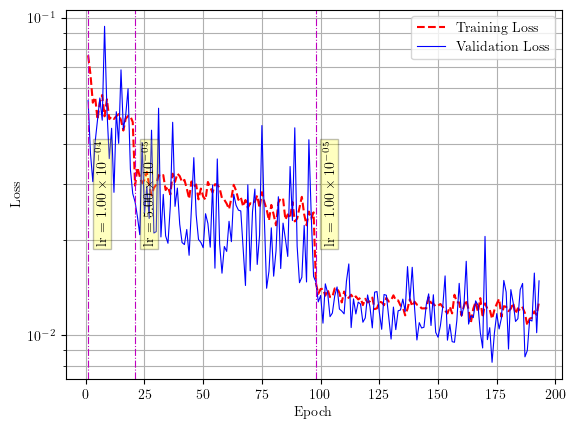

<Figure size 640x480 with 0 Axes>

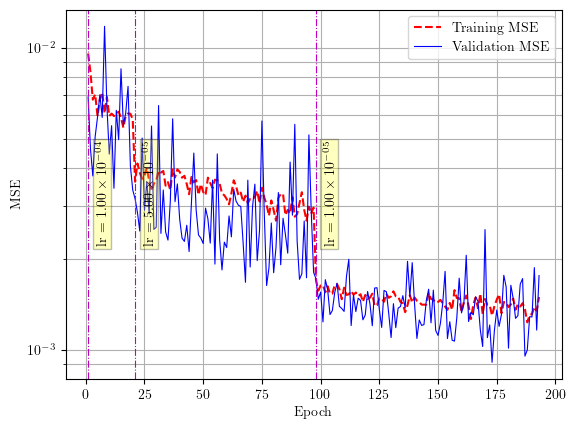

<Figure size 640x480 with 0 Axes>

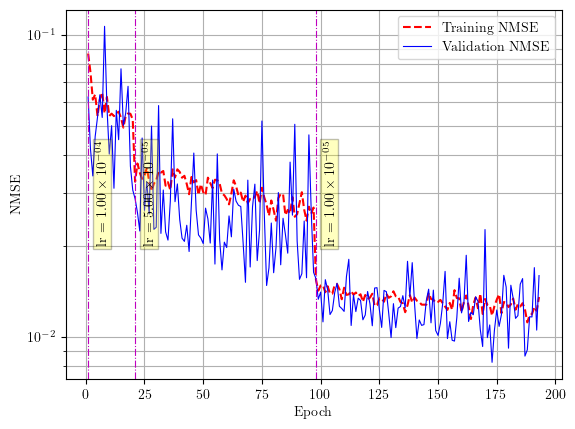

<Figure size 640x480 with 0 Axes>

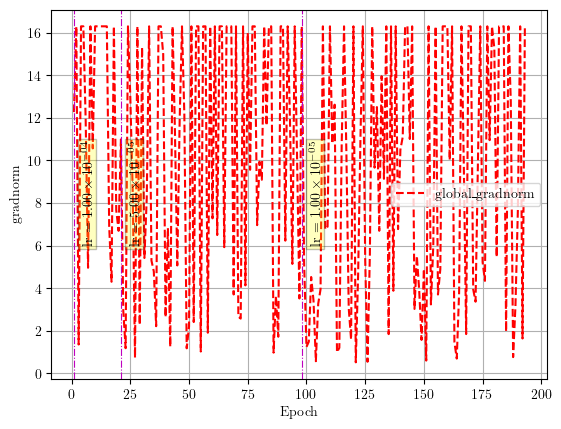



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 15 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : 16.3
50/50 [==============================] - 22s 39ms/step - loss: 0.0356 - mse: 0.0048 - NMSE: 0.0439 - covmat_fro_loss: 0.0000e+00 - global_gradnorm: 0.0000e+00
baseline : 4.3874E-02


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 1e-05 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
403/403 [==============================] - ETA: 0s - loss: 0.0306 - mse: 0.0041 - NMSE: 0.0370 - covmat_fro_loss: 1.8025e-04 - global_gradnorm: 13.8007 - tot_time: 0h 1m 48.3s

Epoch 1: val_NMSE improved from 0.04387 to 0.03332, saving model to /home/rkaushik/Documents/T

403/403 [==============================] - ETA: 0s - loss: 0.0239 - mse: 0.0031 - NMSE: 0.0284 - covmat_fro_loss: 1.6795e-04 - global_gradnorm: 13.3885 - tot_time: 0h 10m 28.7s

Epoch 11: val_NMSE did not improve from 0.02786
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-15_outsteps
403/403 [==============================] - 53s 131ms/step - loss: 0.0239 - mse: 0.0031 - NMSE: 0.0284 - covmat_fro_loss: 1.6791e-04 - global_gradnorm: 13.3957 - val_loss: 0.0290 - val_mse: 0.0038 - val_NMSE: 0.0347 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 12/200
403/403 [==============================] - ETA: 0s - loss: 0.0229 - mse: 0.0030 - NMSE: 0.0272 - covmat_fro_loss: 1.6519e-04 - global_gradnorm: 13.5822 - tot_time: 0h 11m 21.5s

Epoch 12: val_NMSE did not improve from 0.02786
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/A

Epoch 23/200
403/403 [==============================] - ETA: 0s - loss: 0.0212 - mse: 0.0027 - NMSE: 0.0249 - covmat_fro_loss: 1.6356e-04 - global_gradnorm: 13.0746 - tot_time: 0h 20m 56.9s

Epoch 23: val_NMSE did not improve from 0.02555
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-15_outsteps
403/403 [==============================] - 52s 129ms/step - loss: 0.0212 - mse: 0.0027 - NMSE: 0.0249 - covmat_fro_loss: 1.6356e-04 - global_gradnorm: 13.0556 - val_loss: 0.0225 - val_mse: 0.0029 - val_NMSE: 0.0264 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 24/200
403/403 [==============================] - ETA: 0s - loss: 0.0226 - mse: 0.0030 - NMSE: 0.0268 - covmat_fro_loss: 1.6605e-04 - global_gradnorm: 13.5524 - tot_time: 0h 21m 47.8s

Epoch 24: val_NMSE did not improve from 0.02555
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_A

Epoch 35/200
403/403 [==============================] - ETA: 0s - loss: 0.0198 - mse: 0.0026 - NMSE: 0.0232 - covmat_fro_loss: 1.5826e-04 - global_gradnorm: 13.0250 - tot_time: 0h 31m 13.2s

Epoch 35: val_NMSE did not improve from 0.02314
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-15_outsteps
403/403 [==============================] - 51s 126ms/step - loss: 0.0198 - mse: 0.0026 - NMSE: 0.0232 - covmat_fro_loss: 1.5827e-04 - global_gradnorm: 13.0327 - val_loss: 0.0229 - val_mse: 0.0030 - val_NMSE: 0.0270 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 36/200
403/403 [==============================] - ETA: 0s - loss: 0.0197 - mse: 0.0025 - NMSE: 0.0231 - covmat_fro_loss: 1.5959e-04 - global_gradnorm: 13.1531 - tot_time: 0h 32m 4.5s

Epoch 36: val_NMSE did not improve from 0.02314
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR

Epoch 47/200
403/403 [==============================] - ETA: 0s - loss: 0.0205 - mse: 0.0027 - NMSE: 0.0241 - covmat_fro_loss: 1.6023e-04 - global_gradnorm: 13.3804 - tot_time: 0h 41m 32.8s

Epoch 47: val_NMSE did not improve from 0.01979
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-15_outsteps
403/403 [==============================] - 52s 130ms/step - loss: 0.0205 - mse: 0.0027 - NMSE: 0.0241 - covmat_fro_loss: 1.6021e-04 - global_gradnorm: 13.3653 - val_loss: 0.0245 - val_mse: 0.0032 - val_NMSE: 0.0289 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 48/200
403/403 [==============================] - ETA: 0s - loss: 0.0176 - mse: 0.0023 - NMSE: 0.0204 - covmat_fro_loss: 1.5589e-04 - global_gradnorm: 12.7476 - tot_time: 0h 42m 24.5s

Epoch 48: val_NMSE did not improve from 0.01979
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_A

403/403 [==============================] - ETA: 0s - loss: 0.0181 - mse: 0.0023 - NMSE: 0.0210 - covmat_fro_loss: 1.5340e-04 - global_gradnorm: 13.1016 - tot_time: 0h 52m 0.4s

Epoch 59: val_NMSE did not improve from 0.01979
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-15_outsteps
403/403 [==============================] - 53s 130ms/step - loss: 0.0181 - mse: 0.0023 - NMSE: 0.0210 - covmat_fro_loss: 1.5334e-04 - global_gradnorm: 13.1009 - val_loss: 0.0207 - val_mse: 0.0027 - val_NMSE: 0.0242 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 60/200
403/403 [==============================] - ETA: 0s - loss: 0.0181 - mse: 0.0023 - NMSE: 0.0211 - covmat_fro_loss: 1.5446e-04 - global_gradnorm: 12.9728 - tot_time: 0h 52m 52.4s

Epoch 60: val_NMSE did not improve from 0.01979
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR

Epoch 6/200
403/403 [==============================] - ETA: 0s - loss: 0.0149 - mse: 0.0019 - NMSE: 0.0170 - covmat_fro_loss: 1.4760e-04 - global_gradnorm: 11.9939 - tot_time: 1h 2m 25.8s

Epoch 6: val_NMSE did not improve from 0.01979
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-15_outsteps
403/403 [==============================] - 53s 131ms/step - loss: 0.0149 - mse: 0.0019 - NMSE: 0.0170 - covmat_fro_loss: 1.4760e-04 - global_gradnorm: 11.9780 - val_loss: 0.0187 - val_mse: 0.0024 - val_NMSE: 0.0217 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 7/200
403/403 [==============================] - ETA: 0s - loss: 0.0156 - mse: 0.0020 - NMSE: 0.0178 - covmat_fro_loss: 1.4740e-04 - global_gradnorm: 11.7456 - tot_time: 1h 3m 18.0s

Epoch 7: val_NMSE did not improve from 0.01979
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERN

Epoch 18/200
403/403 [==============================] - ETA: 0s - loss: 0.0152 - mse: 0.0019 - NMSE: 0.0175 - covmat_fro_loss: 1.4652e-04 - global_gradnorm: 11.9158 - tot_time: 1h 12m 55.4s

Epoch 18: val_NMSE did not improve from 0.01796
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-15_outsteps
403/403 [==============================] - 53s 131ms/step - loss: 0.0152 - mse: 0.0019 - NMSE: 0.0175 - covmat_fro_loss: 1.4642e-04 - global_gradnorm: 11.8907 - val_loss: 0.0173 - val_mse: 0.0022 - val_NMSE: 0.0199 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 19/200
403/403 [==============================] - ETA: 0s - loss: 0.0151 - mse: 0.0019 - NMSE: 0.0173 - covmat_fro_loss: 1.4609e-04 - global_gradnorm: 12.0467 - tot_time: 1h 13m 46.8s

Epoch 19: val_NMSE improved from 0.01796 to 0.01769, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN

Epoch 30/200
403/403 [==============================] - ETA: 0s - loss: 0.0147 - mse: 0.0019 - NMSE: 0.0168 - covmat_fro_loss: 1.4295e-04 - global_gradnorm: 11.8920 - tot_time: 1h 23m 21.6s

Epoch 30: val_NMSE did not improve from 0.01769
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-15_outsteps
403/403 [==============================] - 53s 131ms/step - loss: 0.0147 - mse: 0.0019 - NMSE: 0.0168 - covmat_fro_loss: 1.4287e-04 - global_gradnorm: 11.9029 - val_loss: 0.0218 - val_mse: 0.0028 - val_NMSE: 0.0255 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 31/200
403/403 [==============================] - ETA: 0s - loss: 0.0140 - mse: 0.0018 - NMSE: 0.0159 - covmat_fro_loss: 1.4216e-04 - global_gradnorm: 11.6934 - tot_time: 1h 24m 13.8s

Epoch 31: val_NMSE did not improve from 0.01769
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_A

Epoch 3/200
403/403 [==============================] - ETA: 0s - loss: 0.0125 - mse: 0.0016 - NMSE: 0.0141 - covmat_fro_loss: 1.4091e-04 - global_gradnorm: 10.8187 - tot_time: 1h 34m 26.1s

Epoch 3: val_NMSE did not improve from 0.01769
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-15_outsteps
403/403 [==============================] - 56s 140ms/step - loss: 0.0125 - mse: 0.0016 - NMSE: 0.0141 - covmat_fro_loss: 1.4087e-04 - global_gradnorm: 10.8323 - val_loss: 0.0164 - val_mse: 0.0021 - val_NMSE: 0.0187 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 4/200
403/403 [==============================] - ETA: 0s - loss: 0.0125 - mse: 0.0016 - NMSE: 0.0141 - covmat_fro_loss: 1.4058e-04 - global_gradnorm: 10.8410 - tot_time: 1h 35m 20.8s

Epoch 4: val_NMSE did not improve from 0.01769
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AE

403/403 [==============================] - ETA: 0s - loss: 0.0128 - mse: 0.0016 - NMSE: 0.0145 - covmat_fro_loss: 1.4035e-04 - global_gradnorm: 10.7661 - tot_time: 1h 45m 43.2s

Epoch 15: val_NMSE did not improve from 0.01769
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-15_outsteps
403/403 [==============================] - 58s 143ms/step - loss: 0.0128 - mse: 0.0016 - NMSE: 0.0145 - covmat_fro_loss: 1.4031e-04 - global_gradnorm: 10.7606 - val_loss: 0.0168 - val_mse: 0.0021 - val_NMSE: 0.0193 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 16/200
403/403 [==============================] - ETA: 0s - loss: 0.0121 - mse: 0.0015 - NMSE: 0.0136 - covmat_fro_loss: 1.3915e-04 - global_gradnorm: 10.3229 - tot_time: 1h 46m 39.8s

Epoch 16: val_NMSE did not improve from 0.01769
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/A

403/403 [==============================] - ETA: 0s - loss: 0.0124 - mse: 0.0015 - NMSE: 0.0139 - covmat_fro_loss: 1.3860e-04 - global_gradnorm: 10.9910 - tot_time: 1h 57m 4.2s

Epoch 27: val_NMSE did not improve from 0.01769
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-15_outsteps
403/403 [==============================] - 58s 144ms/step - loss: 0.0124 - mse: 0.0015 - NMSE: 0.0139 - covmat_fro_loss: 1.3858e-04 - global_gradnorm: 10.9904 - val_loss: 0.0165 - val_mse: 0.0021 - val_NMSE: 0.0189 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 28/200
403/403 [==============================] - ETA: 0s - loss: 0.0129 - mse: 0.0016 - NMSE: 0.0146 - covmat_fro_loss: 1.3952e-04 - global_gradnorm: 10.3575 - tot_time: 1h 57m 59.8s

Epoch 28: val_NMSE did not improve from 0.01769
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR

403/403 [==============================] - ETA: 0s - loss: 0.0123 - mse: 0.0015 - NMSE: 0.0138 - covmat_fro_loss: 1.3765e-04 - global_gradnorm: 10.9534 - tot_time: 2h 8m 23.1s

Epoch 39: val_NMSE did not improve from 0.01769
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-15_outsteps
403/403 [==============================] - 57s 141ms/step - loss: 0.0123 - mse: 0.0015 - NMSE: 0.0138 - covmat_fro_loss: 1.3769e-04 - global_gradnorm: 10.9329 - val_loss: 0.0158 - val_mse: 0.0020 - val_NMSE: 0.0181 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 40/200
403/403 [==============================] - ETA: 0s - loss: 0.0126 - mse: 0.0016 - NMSE: 0.0142 - covmat_fro_loss: 1.3767e-04 - global_gradnorm: 10.4965 - tot_time: 2h 9m 19.1s

Epoch 40: val_NMSE did not improve from 0.01769
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_

403/403 [==============================] - ETA: 0s - loss: 0.0124 - mse: 0.0015 - NMSE: 0.0139 - covmat_fro_loss: 1.3741e-04 - global_gradnorm: 10.7831 - tot_time: 2h 19m 38.3s

Epoch 51: val_NMSE did not improve from 0.01769
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-15_outsteps
403/403 [==============================] - 57s 142ms/step - loss: 0.0124 - mse: 0.0015 - NMSE: 0.0139 - covmat_fro_loss: 1.3750e-04 - global_gradnorm: 10.7618 - val_loss: 0.0171 - val_mse: 0.0022 - val_NMSE: 0.0196 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 52/200
403/403 [==============================] - ETA: 0s - loss: 0.0123 - mse: 0.0015 - NMSE: 0.0138 - covmat_fro_loss: 1.3660e-04 - global_gradnorm: 10.4844 - tot_time: 2h 20m 35.2s

Epoch 52: val_NMSE did not improve from 0.01769
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/A

<Figure size 640x480 with 0 Axes>

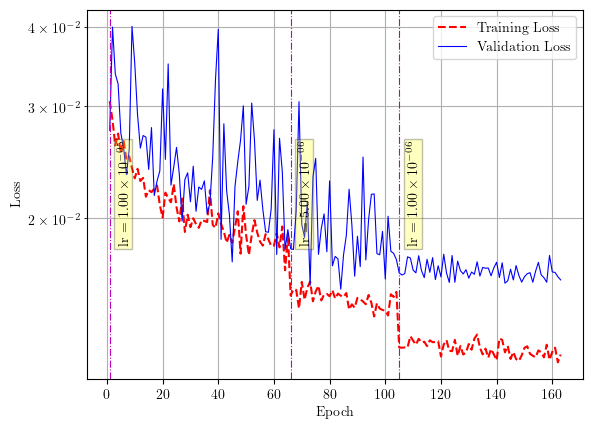

<Figure size 640x480 with 0 Axes>

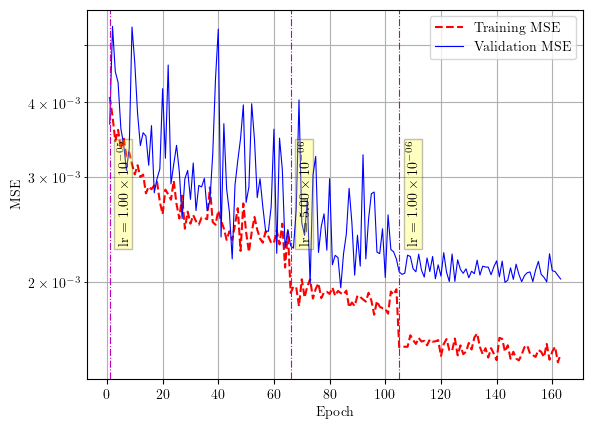

<Figure size 640x480 with 0 Axes>

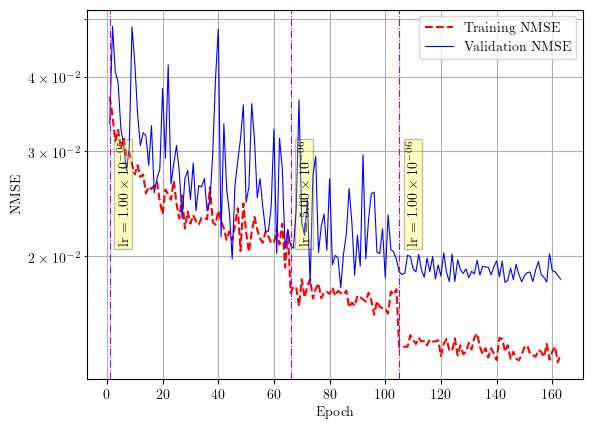

<Figure size 640x480 with 0 Axes>

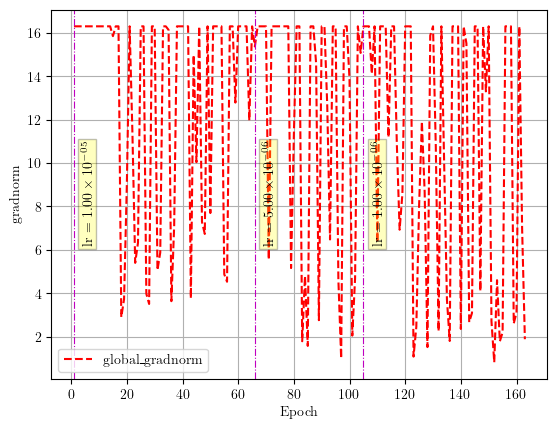



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 20 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : 16.3
42/42 [==============================] - 23s 55ms/step - loss: 0.0308 - mse: 0.0045 - NMSE: 0.0406 - covmat_fro_loss: 0.0000e+00 - global_gradnorm: 0.0000e+00
baseline : 4.0639E-02


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 1e-06 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
338/338 [==============================] - ETA: 0s - loss: 0.0278 - mse: 0.0040 - NMSE: 0.0363 - covmat_fro_loss: 1.9032e-04 - global_gradnorm: 14.6910 - tot_time: 0h 2m 5.8s

Epoch 1: val_NMSE did not improve from 0.04064
 - saving loss histories at /home/rkaushik/Docum

Epoch 11/200
338/338 [==============================] - ETA: 0s - loss: 0.0254 - mse: 0.0036 - NMSE: 0.0328 - covmat_fro_loss: 1.8955e-04 - global_gradnorm: 14.6176 - tot_time: 0h 12m 3.2s

Epoch 11: val_NMSE improved from 0.03480 to 0.03381, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/checkpoint-20_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-20_outsteps
338/338 [==============================] - 60s 178ms/step - loss: 0.0254 - mse: 0.0036 - NMSE: 0.0328 - covmat_fro_loss: 1.8963e-04 - global_gradnorm: 14.6226 - val_loss: 0.0262 - val_mse: 0.0037 - val_NMSE: 0.0338 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 12/200
338/338 [==============================] - ETA: 0s - loss: 0.0259 - mse: 0.0037 - NMSE: 0.0334 - covmat_fro_loss: 1.9084e-04 - global_gradnorm: 14.7602 - tot_time: 0h 13m 3.2s


Epoch 23/200
338/338 [==============================] - ETA: 0s - loss: 0.0252 - mse: 0.0036 - NMSE: 0.0324 - covmat_fro_loss: 1.9193e-04 - global_gradnorm: 14.6483 - tot_time: 0h 23m 58.3s

Epoch 23: val_NMSE did not improve from 0.03279
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-20_outsteps
338/338 [==============================] - 60s 177ms/step - loss: 0.0252 - mse: 0.0036 - NMSE: 0.0324 - covmat_fro_loss: 1.9202e-04 - global_gradnorm: 14.6532 - val_loss: 0.0263 - val_mse: 0.0037 - val_NMSE: 0.0338 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 24/200
338/338 [==============================] - ETA: 0s - loss: 0.0244 - mse: 0.0035 - NMSE: 0.0313 - covmat_fro_loss: 1.9051e-04 - global_gradnorm: 14.3122 - tot_time: 0h 24m 58.6s

Epoch 24: val_NMSE did not improve from 0.03279
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_A

Epoch 35/200
338/338 [==============================] - ETA: 0s - loss: 0.0230 - mse: 0.0032 - NMSE: 0.0294 - covmat_fro_loss: 1.9199e-04 - global_gradnorm: 14.6285 - tot_time: 0h 35m 57.5s

Epoch 35: val_NMSE did not improve from 0.03098
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-20_outsteps
338/338 [==============================] - 60s 177ms/step - loss: 0.0230 - mse: 0.0032 - NMSE: 0.0294 - covmat_fro_loss: 1.9190e-04 - global_gradnorm: 14.6334 - val_loss: 0.0252 - val_mse: 0.0036 - val_NMSE: 0.0323 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 36/200
338/338 [==============================] - ETA: 0s - loss: 0.0233 - mse: 0.0033 - NMSE: 0.0298 - covmat_fro_loss: 1.9265e-04 - global_gradnorm: 14.5020 - tot_time: 0h 36m 57.1s

Epoch 36: val_NMSE did not improve from 0.03098
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_A

Epoch 47/200
338/338 [==============================] - ETA: 0s - loss: 0.0239 - mse: 0.0034 - NMSE: 0.0304 - covmat_fro_loss: 1.9476e-04 - global_gradnorm: 14.5217 - tot_time: 0h 47m 53.8s

Epoch 47: val_NMSE did not improve from 0.03087
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-20_outsteps
338/338 [==============================] - 59s 174ms/step - loss: 0.0239 - mse: 0.0034 - NMSE: 0.0304 - covmat_fro_loss: 1.9472e-04 - global_gradnorm: 14.5269 - val_loss: 0.0253 - val_mse: 0.0036 - val_NMSE: 0.0323 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 48/200
338/338 [==============================] - ETA: 0s - loss: 0.0232 - mse: 0.0033 - NMSE: 0.0295 - covmat_fro_loss: 1.9458e-04 - global_gradnorm: 14.6348 - tot_time: 0h 48m 52.7s

Epoch 48: val_NMSE did not improve from 0.03087
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_A

338/338 [==============================] - ETA: 0s - loss: 0.0226 - mse: 0.0032 - NMSE: 0.0287 - covmat_fro_loss: 1.9548e-04 - global_gradnorm: 14.4720Restoring model weights from the end of the best epoch: 39.
 - tot_time: 0h 59m 49.9s

Epoch 59: val_NMSE did not improve from 0.03087
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-20_outsteps
338/338 [==============================] - 60s 179ms/step - loss: 0.0226 - mse: 0.0032 - NMSE: 0.0287 - covmat_fro_loss: 1.9544e-04 - global_gradnorm: 14.4774 - val_loss: 0.0261 - val_mse: 0.0037 - val_NMSE: 0.0332 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 59: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 5e-07 -----------------------------

--------------------------------------------------------------------------------


Ep

Epoch 12/200
338/338 [==============================] - ETA: 0s - loss: 0.0225 - mse: 0.0032 - NMSE: 0.0286 - covmat_fro_loss: 1.9200e-04 - global_gradnorm: 14.3343 - tot_time: 1h 11m 47.1s

Epoch 12: val_NMSE did not improve from 0.03048
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-20_outsteps
338/338 [==============================] - 60s 176ms/step - loss: 0.0225 - mse: 0.0032 - NMSE: 0.0286 - covmat_fro_loss: 1.9217e-04 - global_gradnorm: 14.3401 - val_loss: 0.0254 - val_mse: 0.0036 - val_NMSE: 0.0325 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 13/200
338/338 [==============================] - ETA: 0s - loss: 0.0224 - mse: 0.0031 - NMSE: 0.0285 - covmat_fro_loss: 1.9204e-04 - global_gradnorm: 14.3019 - tot_time: 1h 12m 46.6s

Epoch 13: val_NMSE did not improve from 0.03048
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_A

338/338 [==============================] - ETA: 0s - loss: 0.0221 - mse: 0.0031 - NMSE: 0.0280 - covmat_fro_loss: 1.9276e-04 - global_gradnorm: 13.8922 - tot_time: 1h 23m 42.0s

Epoch 24: val_NMSE did not improve from 0.03048
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-20_outsteps
338/338 [==============================] - 60s 177ms/step - loss: 0.0221 - mse: 0.0031 - NMSE: 0.0280 - covmat_fro_loss: 1.9290e-04 - global_gradnorm: 13.8993 - val_loss: 0.0247 - val_mse: 0.0035 - val_NMSE: 0.0315 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 25/200
338/338 [==============================] - ETA: 0s - loss: 0.0219 - mse: 0.0031 - NMSE: 0.0278 - covmat_fro_loss: 1.9304e-04 - global_gradnorm: 14.2285 - tot_time: 1h 24m 43.2s

Epoch 25: val_NMSE did not improve from 0.03048
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/A

Epoch 10/200
338/338 [==============================] - ETA: 0s - loss: 0.0216 - mse: 0.0030 - NMSE: 0.0274 - covmat_fro_loss: 1.9212e-04 - global_gradnorm: 14.3324 - tot_time: 1h 35m 40.4s

Epoch 10: val_NMSE did not improve from 0.03048
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_AR_AERNN_rnn/AR_rnn_005/checkpoints/LossHistoriesCheckpoint-20_outsteps
338/338 [==============================] - 60s 176ms/step - loss: 0.0216 - mse: 0.0030 - NMSE: 0.0274 - covmat_fro_loss: 1.9219e-04 - global_gradnorm: 14.3382 - val_loss: 0.0246 - val_mse: 0.0035 - val_NMSE: 0.0314 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 11/200
338/338 [==============================] - ETA: 0s - loss: 0.0225 - mse: 0.0032 - NMSE: 0.0286 - covmat_fro_loss: 1.9252e-04 - global_gradnorm: 14.2299 - tot_time: 1h 36m 38.6s

Epoch 11: val_NMSE did not improve from 0.03048
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_lorenz/saved_A

<Figure size 640x480 with 0 Axes>

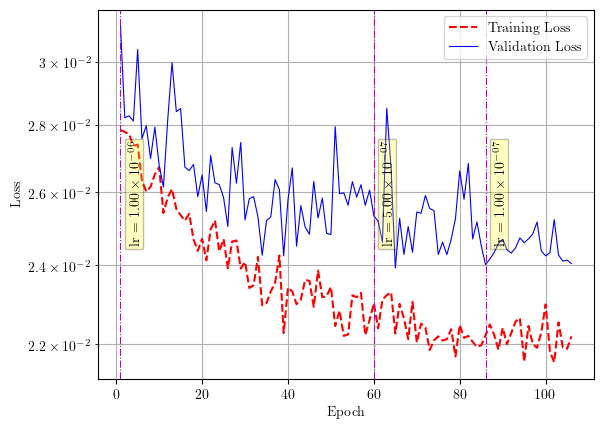

<Figure size 640x480 with 0 Axes>

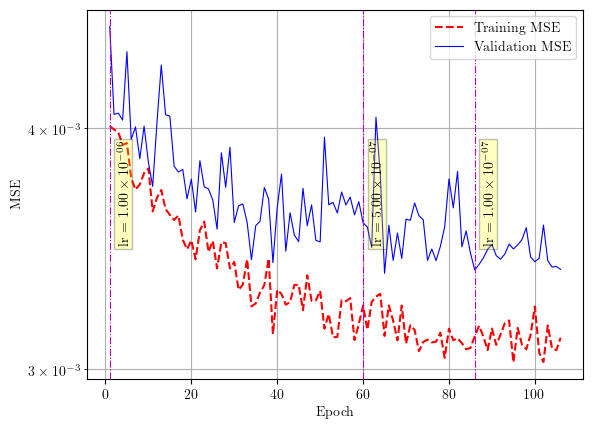

<Figure size 640x480 with 0 Axes>

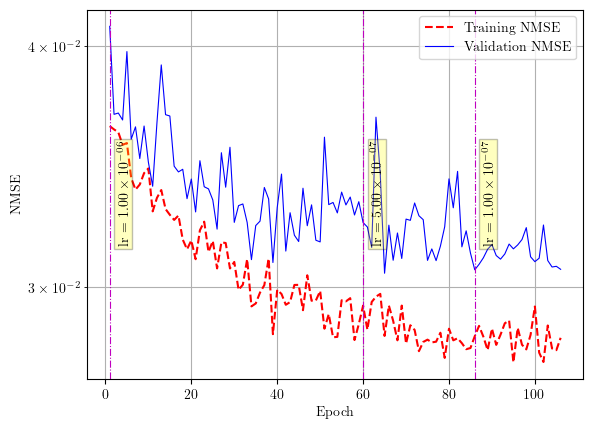

<Figure size 640x480 with 0 Axes>

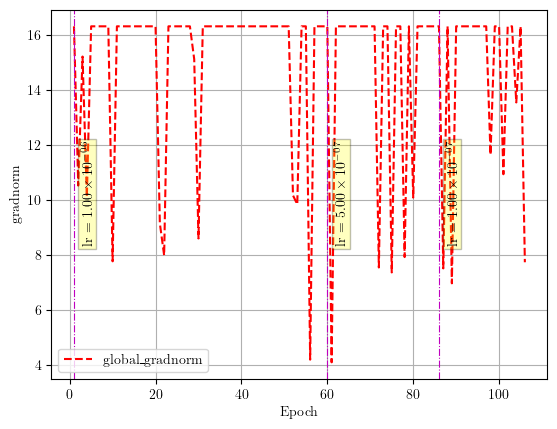

<Figure size 640x480 with 0 Axes>

In [19]:
global_clipnorm = None
for kk in range(len(T_sample_output)):

    num_outsteps = int((T_sample_output[kk] + 0.5*dt_rnn)//dt_rnn)
    if type(freeze_layers) == type(None):
        freeze_layers_thisoutstep = []
    else:
        if kk > len(freeze_layers) - 1:
            freeze_layers_thisoutstep = freeze_layers[-1]
        else:
            freeze_layers_thisoutstep = freeze_layers[kk]
        
        if type(freeze_layers_thisoutstep) == type(None):
            freeze_layers_thisoutstep = []
            
    if type(batch_size) == type([]):
        if kk > len(batch_size) - 1:
            batch_size_thisoutstep = batch_size[-1]
        else:
            batch_size_thisoutstep = batch_size[kk]
    else:
        batch_size_thisoutstep = batch_size

    total_s_len = 80
    sep_lr_s = ' num_outsteps : {} '.format(num_outsteps)
    sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'>' + sep_lr_s
    sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'<'
    print('\n\n' + '*'*len(sep_lr_s))
    print('' + sep_lr_s+'')
    print('*'*len(sep_lr_s) + '\n\n')

    print('clipnorm : {}, global_clipnorm : {}'.format(clipnorm, global_clipnorm))
    
    trainAERNN(
        create_data_for_RNN,
        Autoencoder,
        AR_RNN,
        all_data,
        AR_AERNN_GRU,
        dt_rnn=dt_rnn,
        T_sample_input=T_sample_input,
        T_sample_output=T_sample_output[kk],
        T_offset=T_offset,
        boundary_idx_arr=boundary_idx_arr,
        delta_t=delta_t,
        params=params,
        normalize_dataset=normalize_dataset,
        stddev_multiplier=stddev_multiplier,
        skip_intermediate=skip_intermediate,
        normalization_type=normalization_type,
        normalization_constant_arr_aedata=normalization_constant_arr_aedata,
        normalization_constant_arr_rnndata=normalization_arr_rnn,
        learning_rate_list=learning_rate_list[kk],
        epochs=epochs[kk],
        patience=patience[kk],
        loss_weights=loss_weights,
        min_delta=min_delta,
        lambda_reg=lambda_reg,
        stddev_rnn=stddev,
        stateful=False,
        behaviour=behaviour,
        strategy=strategy,
        dir_name_rnn=dir_name_rnn,
        dir_name_AR_AErnn=dir_name_ARrnn,
        batch_size=batch_size_thisoutstep,
        load_file_rnn=load_file_rnn,
        wt_file_rnn=wt_file_rnn,
        load_file_ae=load_file_ae,
        wt_file_ae=wt_file_ae,
        covmat_lmda=covmat_lmda,
        readAndReturnLossHistories=readAndReturnLossHistories,
        mytimecallback=mytimecallback,
        plot_losses=plot_losses,
        SaveLosses=SaveLosses,
        train_split=train_split,
        test_split=test_split,
        val_split=val_split,
        freeze_layers=freeze_layers_thisoutstep,
        clipnorm=clipnorm,
        global_clipnorm=global_clipnorm,
        use_ae_data=use_ae_data,
    )
    
    wt_file_rnn = dir_name_ARrnn+'/final_net/final_net-{}_outsteps_rnn_weights.h5'.format(num_outsteps)
    wt_file_ae = dir_name_ARrnn+'/final_net/final_net-{}_outsteps_ae_weights.h5'.format(num_outsteps)
    
    with open(dir_name_ARrnn+'/final_net/losses-{}_outsteps.txt'.format(num_outsteps), 'r') as fl:
        lines = fl.readlines()

    loss_dict = eval(''.join(lines))
    train_global_gradnorm_hist = loss_dict['train_global_gradnorm_hist']
    # lr_change = loss_dict['lr_change']
    # trained_epochs = len(train_global_gradnorm_hist)
    # if lr_change[-1] - lr_change[-2] == epochs[kk][-1]:
    #     global_clipnorm = train_global_gradnorm_hist[-1]
    # else:
    #     global_clipnorm = train_global_gradnorm_hist[-patience[kk][-1]]

    # alpha1 = 0.9
    # alpha2 = 0.1
    # global_clipnorm = train_global_gradnorm_hist[0]
    # for i in range(1, len(train_global_gradnorm_hist)):
    #     global_clipnorm = alpha1*global_clipnorm + alpha2*train_global_gradnorm_hist[i]

#     grad_norm_decay = 0.95
#     idxs_to_ignore = 0

#     global_clipnorm = np.max(train_global_gradnorm_hist[idxs_to_ignore:])
#     # global_clipnorm = 0.25 * np.round(4*global_clipnorm)
#     global_clipnorm = grad_norm_decay * global_clipnorm
    idxs_to_ignore = 1
    global_clipnorm_min = 3.0
    global_clipnorm = np.max(train_global_gradnorm_hist[idxs_to_ignore:])
    global_clipnorm = 0.1 * np.round(10*global_clipnorm)
    global_clipnorm = max(global_clipnorm, global_clipnorm_min)

In [20]:
a = 123e-5
a

0.00123

In [21]:
s = '{:E}'.format(a)
s

'1.230000E-03'

In [22]:
idx = s.find('E')
num = float(s[0:idx])
10**float(s[idx+1:])

0.001

In [23]:
### Training the combined AE-RNN


# 